## Fundamentals of ML
### Building a WaveNet

<br />

### [Makemore](https://github.com/karpathy/makemore) by Andrej Karpathy
### [WaveNet 2016 from DeepMind](https://arxiv.org/abs/1609.03499)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [6]:
words = open('../ml_with_python/resources/names.txt', 'r').read().splitlines()
print(words[:7])
print(max(len(w) for w in words))
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']
15
32033


In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos, '\n', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 27


In [8]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
for x,y in zip(Xtr[:10], Ytr[:10]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o


In [12]:
# Near copy-paste of the layers we have developed in previous parts
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1) # important difference with PyTorch implementation
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [13]:
torch.manual_seed(42) # for reproducibility

In [15]:
# MLP network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # the last layer make less confident
# dimensions of C: (vocab_size, n_embd)
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3009
  10000/ 200000: 2.2558
  20000/ 200000: 2.0448
  30000/ 200000: 1.9628
  40000/ 200000: 2.6019
  50000/ 200000: 2.3491
  60000/ 200000: 2.4057
  70000/ 200000: 1.9998
  80000/ 200000: 1.7738
  90000/ 200000: 2.1271
 100000/ 200000: 1.9799
 110000/ 200000: 2.0661
 120000/ 200000: 2.2353
 130000/ 200000: 2.2805
 140000/ 200000: 2.0675
 150000/ 200000: 2.1004
 160000/ 200000: 1.8342
 170000/ 200000: 2.1820
 180000/ 200000: 2.2115
 190000/ 200000: 1.9646


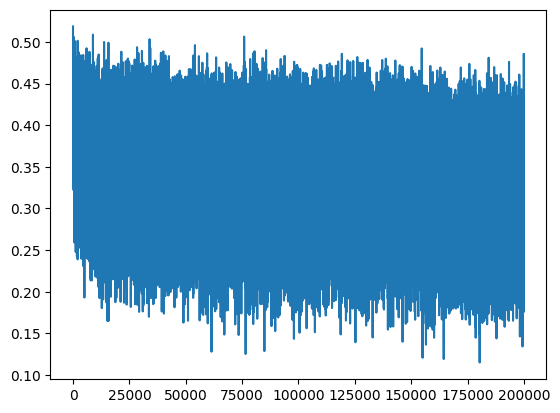

In [17]:
plt.plot(lossi);

In [18]:
for layer in layers:
  layer.training = False

In [19]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0581843852996826
val 2.104032516479492


In [20]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

zylee.
jancatel.
rosen.
graylie.
izayvion.
plar.
bren.
anorionnie.
aize.
jaimulee.
kaii.
ayleus.
kashany.
elw.
pat.
catalmina.
zin.
noel.
karhanah.
jakadie.


### Let's improve the model =)

In [21]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

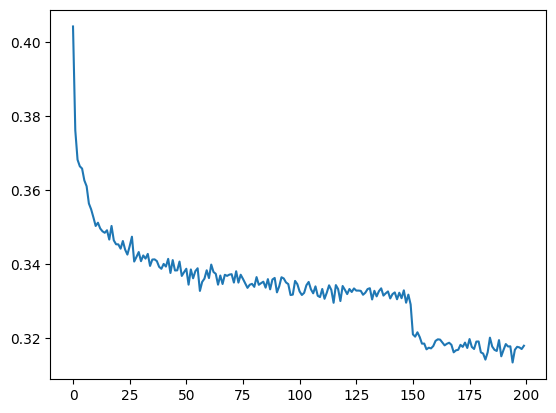

In [22]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [25]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape # batch_size, token_amount, emb_size
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


![pytorch_containers](./images/pytorch_containers.png)

In [26]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(), 
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # the last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

17997


In [27]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.2974


![dil_caus_conv](./images/dil_caus_conv.png)

In [28]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [29]:
for x,y in zip(Xtr[:10], Ytr[:10]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o


In [30]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(), 
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [31]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3042
  10000/ 200000: 1.8774
  20000/ 200000: 1.8766
  30000/ 200000: 2.1377
  40000/ 200000: 2.0938
  50000/ 200000: 2.0381
  60000/ 200000: 2.0605
  70000/ 200000: 2.3292
  80000/ 200000: 2.0317
  90000/ 200000: 2.0716
 100000/ 200000: 1.6291
 110000/ 200000: 1.9861
 120000/ 200000: 2.1413
 130000/ 200000: 1.7638
 140000/ 200000: 1.8565
 150000/ 200000: 2.1100
 160000/ 200000: 2.5573
 170000/ 200000: 1.9236
 180000/ 200000: 2.3113
 190000/ 200000: 1.9005


### Understanding the model

In [33]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # for a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  5, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  9]])

In [34]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([4, 8, 10])

In [35]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [38]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [39]:
(torch.randn(4, 80) @ torch.randn(80, 200)  + torch.randn(200)).shape

torch.Size([4, 200])

In [40]:
(torch.randn(4, 5, 80) @ torch.randn(80, 200)  + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [31]:
# 1 2 3 4 5 6 7 8 -> (1 2) (3 4) (5 6) (7 8)

In [41]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200)  + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [42]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [43]:
e = torch.randn(4, 8, 10) # we want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
print(e[:, ::2, :].shape)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
print(explicit.shape)

torch.Size([4, 4, 10])
torch.Size([4, 4, 20])


In [35]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [45]:
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape # batch_size, token_amount, emb_size
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

In [47]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(block_size), 
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 10 # 24 # the dimensionality of the character embedding vectors
n_hidden = 68 # 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # the last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [48]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # for a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  1,  9, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 22,  1, 18, 22,  1, 18,  1]])

In [49]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [50]:

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2952
  10000/ 200000: 2.3283
  20000/ 200000: 2.0356
  30000/ 200000: 2.3032
  40000/ 200000: 2.2529
  50000/ 200000: 1.9075
  60000/ 200000: 2.2362
  70000/ 200000: 1.9082
  80000/ 200000: 1.8402
  90000/ 200000: 2.5294
 100000/ 200000: 1.8903
 110000/ 200000: 2.0957
 120000/ 200000: 2.3785
 130000/ 200000: 1.6885
 140000/ 200000: 1.6992
 150000/ 200000: 2.0348
 160000/ 200000: 1.9747
 170000/ 200000: 2.1710
 180000/ 200000: 2.0856
 190000/ 200000: 1.9901


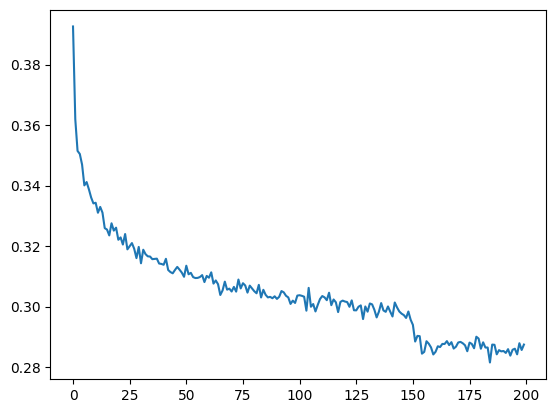

In [51]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [52]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [53]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9119105339050293
val 2.028068780899048


In [54]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kyree.
rona.
jamariah.
ivean.
jacison.
bonay.
alassadee.
gloree.
kentley.
jerelie.
trabella.
maxwona.
innly.
dielj.
rilee.
ahstr.
lillion.
samaya.
prentredymy.
keedie.


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


### Next time: Why convolutions? Brief preview/hint

In [55]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [46]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [47]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [48]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space

### What else can you watch?

[Building makemore Part 5: Building a WaveNet](https://youtu.be/t3YJ5hKiMQ0) video by Andrej Karpathy.

